# Objective

Determine the functional differences (if any exist to be found) in the proteome of the microbiome between RAG-Tcell Transfer (IBD Model) and RAG (Helthy Control) mice.  Ratio quantification using N15 isotopic labeling of the proteins of the microbiome should help to elucidate minor differences, while spectoral counting methods will be used to identify gross differences in proteomic content.

## Read and store sample data as classes

In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import shelve
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text

from scripts import utils
from scripts.analysis import build_loci
from scripts.analysis.DBInfo import DBInfo

BASE = '../data'

db_info = DBInfo("compil_mgm")
metadata = build_loci.read_metadata(os.path.join(BASE,"metadata.csv"))

`metadata.csv` was generated using the script `make_metadata.py` located in the `scripts` directory.  This file extracts metadata about each sample encoded into the directory names, and places them into a csv file that is used by build loci to perform the correct analysis pipelines on a given sample.

In [2]:
samples = shelve.open(os.path.join(BASE,"Samples.shelve"))
"""
for sample_name, sample_info in tqdm(list(metadata.iteritems())):
    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)
    samples[sample.sample_name] = sample
"""

'\nfor sample_name, sample_info in tqdm(list(metadata.iteritems())):\n    sample = build_loci.Sample(sample_name, sample_info.path, db_info, sample_info)\n    samples[sample.sample_name] = sample\n'

In [3]:
protein_clusters = shelve.open(os.path.join(BASE,"Protein_clusters.shelve"))
"""
for name, sample in tqdm(samples.items()):
    protein_clusters[name] = sample.build_protein_clusters()
"""

'\nfor name, sample in tqdm(samples.items()):\n    protein_clusters[name] = sample.build_protein_clusters()\n'

Get the list of N15 quantified, unenriched samples.

In [4]:
unenr_keys = []
for key, sample in samples.items():
    if sample['quant'] and not sample['enriched']:
        unenr_keys.append(key)
unenr_keys = sorted(unenr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [5]:
rt_un_keys = [key for key in unenr_keys if not '_N_' in key]
rag_un_keys = [key for key in unenr_keys if '_N_' in key]

## Plot venn diagrams showing run to run cluster composition for the samples

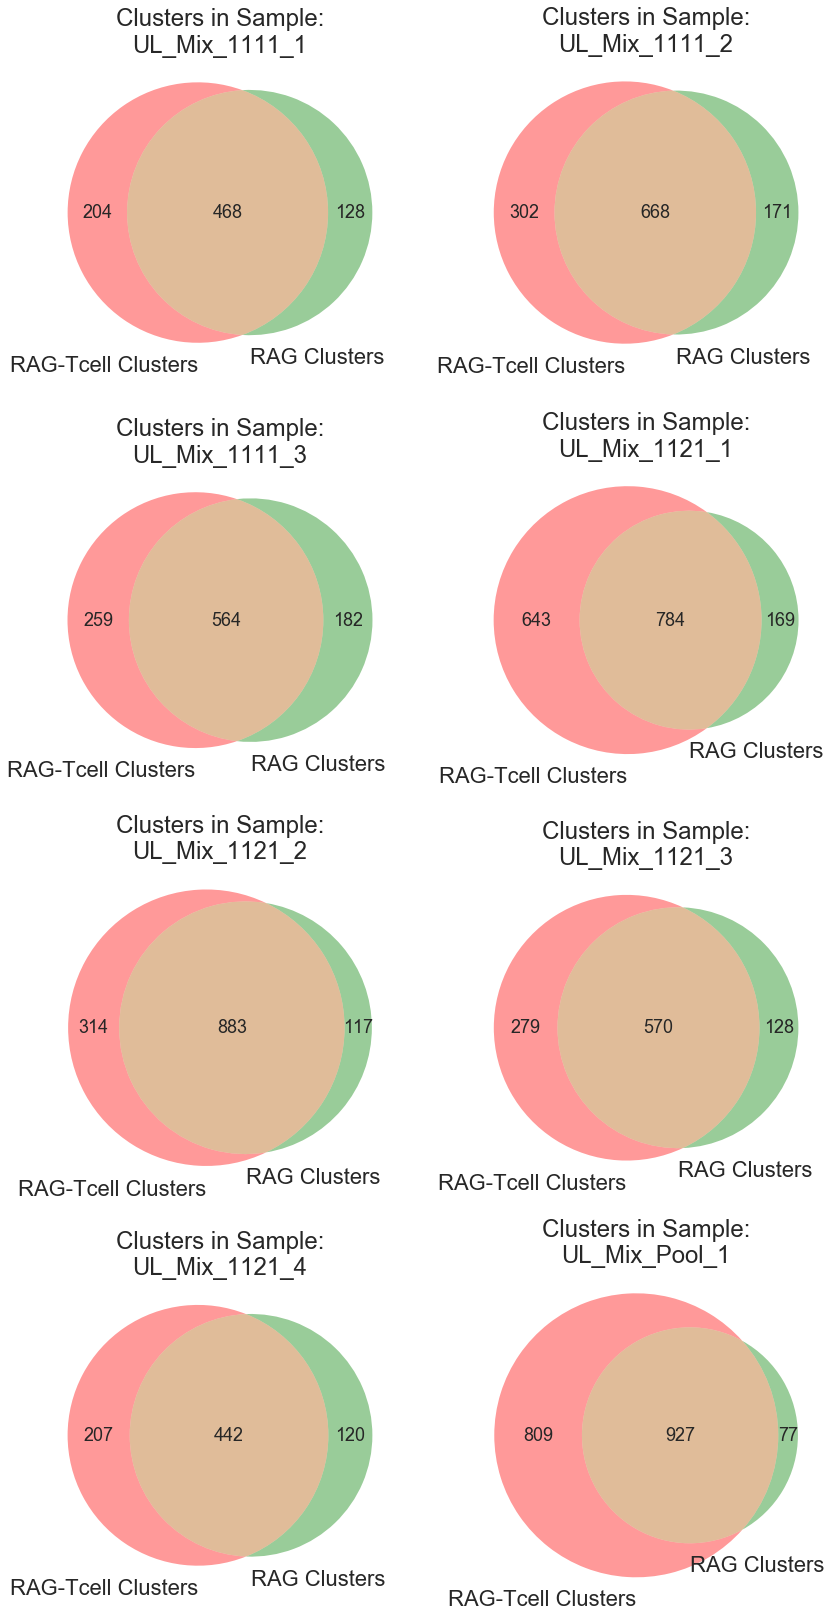

In [6]:
from matplotlib_venn import venn2

rows = len(unenr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,28)

for i, (l, h) in enumerate(zip(rt_un_keys, rag_un_keys)):
    light = set(p.cluster_id for p in protein_clusters[l])
    heavy = set(p.cluster_id for p in protein_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'unenr_clusters.png'), dpi = 100);

`UL_Mix_1121_1` (Row 2, Right side) and `UL_Mix_Pool_1` (Bottom Row, Right side) both look like they have diminished RAG Clusters, definitely looking different from the rest.  

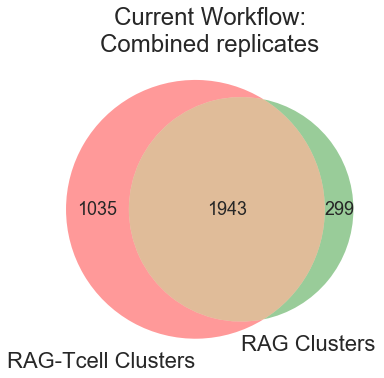

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_tight_layout(False)


rt_clust = set()
rag_clust = set()
for i, (l, h) in enumerate(zip(rt_un_keys, rag_un_keys)):
    rt_clust.update(set(p.cluster_id for p in protein_clusters[l]))
    rag_clust.update(set(p.cluster_id for p in protein_clusters[h]))
v = venn2((rt_clust, rag_clust), ('RAG-Tcell Clusters', 'RAG Clusters'))
    
for txt in v.set_labels:
    txt.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(18)
plt.title('Current Workflow:\nCombined replicates', size = 24);

## Make Datatables from the data

In [8]:
"""
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in unenr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in unenr_keys}

unenr_grouped_loci = build_loci.group_across_samples(list(chain(*unenr_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(unenr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys) #Only quantify ratios across N14 identifications
"""

unenr_grouped_loci = utils.load(os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"))

In [9]:
unenr_samples = {k:v for k, v in samples.items() if k in unenr_keys}
nf = build_loci.yates_normalization(unenr_samples)

316 common peptides for Normalizaion


In [10]:
for locus in unenr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(unenr_grouped_loci, unenr_keys, os.path.join(BASE, 'unenriched_Rag_Tcell_ratio.json'))

#Uncomment on first runthrough:
#utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci.pkl.gz"), force=True)

### Datatable Link
**[Unenriched Protein Clusters](http://wl-cmadmin:8000/ratiotable/unenriched_Rag_Tcell_ratio)**

## PCA Plot of the Unenriched Samples

explained variance ratios: [ 0.20009155  0.14410704]


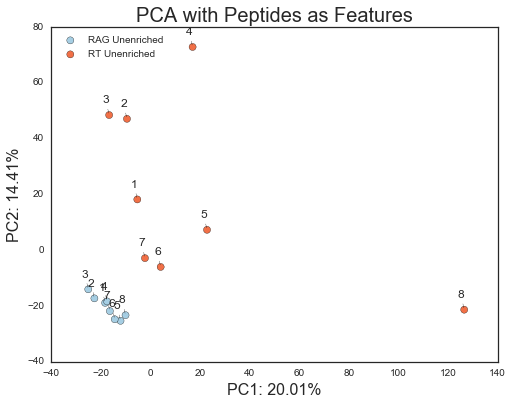

In [11]:
df = build_loci.to_df(unenr_grouped_loci, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys], title='PCA with Peptides as Features', group_name='category', loc=2, label_points=True)

Sample 8 looks like it could be an outlier, as well as potentially Sample 4.  We will remember this and look into it, but first lets prep the data for the Enriched Samples

# Enriched Samples

In [12]:
enr_keys = []
ctl_keys = []
for key, sample in samples.items():
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'CMK' and sample['col_date']:
        enr_keys.append(key)
    if sample['quant'] and sample['enriched'] and sample['probe'] == 'DMSO':
        ctl_keys.append(key)
enr_keys = sorted(enr_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))
ctl_keys = sorted(ctl_keys, key=lambda x: (x.split('_')[2], x.split('_')[-1], x.split('_')[-2]=='N'))

In [13]:
rt_enr_keys = [key for key in enr_keys if not '_N_' in key]
rag_enr_keys = [key for key in enr_keys if '_N_' in key]

## Filter out clusters commonly found in DMSO Controls

If 10+ counts in a sample, most likely, this locus has a non-specific interaction to the beads, and isn't just noise

In [14]:
loci_to_filter = []
all_loci = []
for sample in ctl_keys:
    for locus in protein_clusters[sample]:
        if locus.quantification['counts'] >= 10:
            loci_to_filter.append(locus.cluster_id)
        all_loci.append(locus.cluster_id)
loci_to_filter = set(loci_to_filter)
all_loci = set(all_loci)

print('Total Loci in DMSO Samps: {}'.format(len(all_loci)))
print('Loci with enough counts to filter: {}\n\n'.format(len(loci_to_filter)))


print('Filtering per sample:\nSample\t\tBeforeFilt\tAfterFilt\tTotalFiltered')
filt_clusters = dict()
for sample in enr_keys:
    count = 0
    a = protein_clusters[sample]
    print('{}\t{}'.format(sample, len(a)), end='')
    for locus in protein_clusters[sample]:
        if locus.cluster_id in loci_to_filter:
            a.remove(locus)
            count += 1
    print('\t\t{}\t\t{}'.format(len(a), count))
    filt_clusters[sample] = a

Total Loci in DMSO Samps: 415
Loci with enough counts to filter: 248


Filtering per sample:
Sample		BeforeFilt	AfterFilt	TotalFiltered
CL_Mix_1120_1	1581		1483		98
CL_Mix_1120_N_1	667		636		31
CL_Mix_Pool_1	1550		1396		154
CL_Mix_Pool_N_1	868		829		39
CL_Mix_Pool_2	740		637		103
CL_Mix_Pool_N_2	530		500		30
CL_Mix_Pool_3	1147		1021		126
CL_Mix_Pool_N_3	640		604		36
CL_Mix_Pool_4	800		679		121
CL_Mix_Pool_N_4	357		326		31
CL_Mix_Pool_5	1568		1432		136
CL_Mix_Pool_N_5	581		545		36


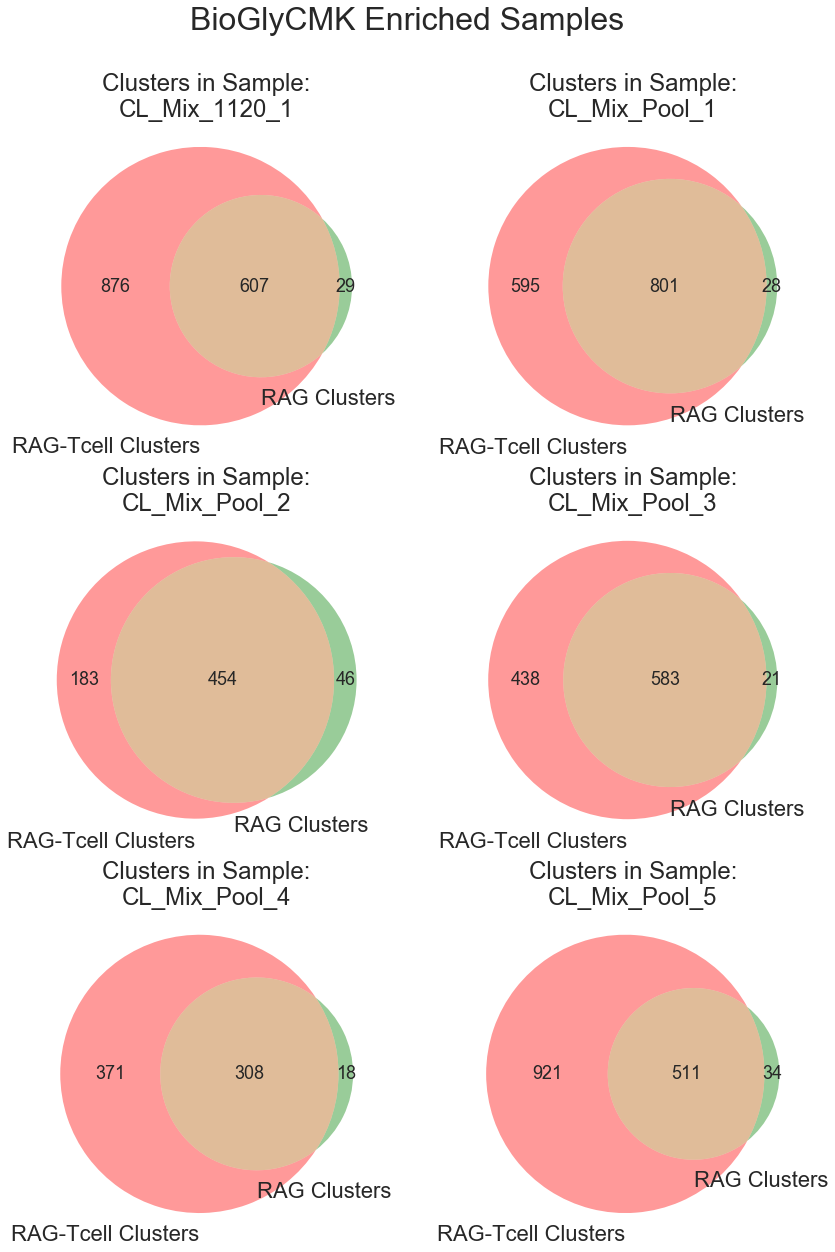

In [15]:
rows = len(enr_keys)//4

fig, ax = plt.subplots(rows,2)
fig.set_tight_layout(False)
fig.set_size_inches(14,20)
fig.suptitle('BioGlyCMK Enriched Samples', size=32)


for i, (l, h) in enumerate(zip(rt_enr_keys, rag_enr_keys)):
    light = set(p.cluster_id for p in filt_clusters[l])
    heavy = set(p.cluster_id for p in filt_clusters[h])
    
    v = venn2((light, heavy), ('RAG-Tcell Clusters', 'RAG Clusters'), ax = ax[i//2][i%2])
    
    for txt in v.set_labels:
        txt.set_fontsize(22)
    for text in v.subset_labels:
        text.set_fontsize(18)
    ax[i//2][i%2].set_title('Clusters in Sample:\n{}'.format(l), size = 24)

plt.savefig(os.path.join(BASE, 'enr_clusters.png'), dpi = 100);

In [16]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in enr_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in enr_keys}

enr_grouped_loci = build_loci.group_across_samples(list(chain(*filt_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(enr_grouped_loci):
    locus.annotate()
    locus.quantify(rt_enr_keys) #Only quantify ratios across N14 identifications
"""
enr_grouped_loci = utils.load(os.path.join(BASE,"enriched_grouped_loci.pkl.gz"))

In [17]:
enriched_samples = {k:v for k, v in samples.items() if k in enr_keys}
nf = build_loci.yates_normalization(enriched_samples)

for locus in enr_grouped_loci:
    locus.normalize(nf)
build_loci.to_json(enr_grouped_loci, enr_keys, '../data/bioGlyCMK_enriched_Rag_Tcell_ratio.json')

#utils.save(enr_grouped_loci, os.path.join(BASE,"enriched_grouped_loci.pkl.gz"), force=True)

292 common peptides for Normalizaion


### Datatable of loci and all Enriched samples
**[Link to Datatable](http://wl-cmadmin:8000/ratiotable/bioGlyCMK_enriched_Rag_Tcell_ratio)**

explained variance ratios: [ 0.27021321  0.23597624]


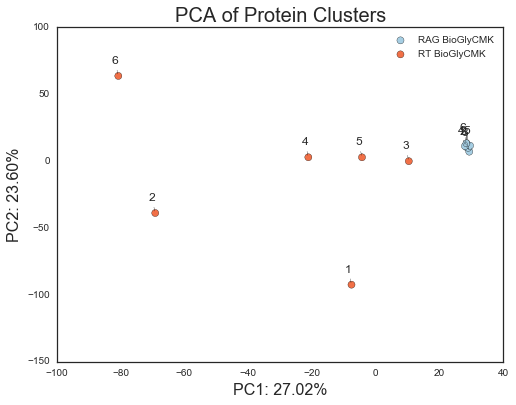

In [18]:
df = build_loci.to_df(enr_grouped_loci, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys], group_name='category', loc=1, label_points=True)

# Unenriched and Enriched Samples

In [19]:
unenr_clusters = {k:v for k, v in protein_clusters.items() if k in unenr_keys}
both_clusters = filt_clusters
both_clusters.update(unenr_clusters)
both_keys = enr_keys + unenr_keys

In [20]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in both_keys}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in both_keys}
grouped_loci = build_loci.group_across_samples(list(chain(*both_clusters.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(grouped_loci):
    locus.annotate()
    locus.quantify(rt_un_keys+rt_enr_keys) #Only quantify ratios across N14 identifications
"""
grouped_loci = utils.load(os.path.join(BASE,"grouped_loci.pkl.gz"))

In [21]:
both_samples = {k:v for k, v in samples.items() if k in both_keys}
nf = build_loci.yates_normalization(both_samples)
for locus in grouped_loci:
    locus.normalize(nf)
    
#utils.save(grouped_loci, os.path.join(BASE,"grouped_loci.pkl.gz"), force=True)

205 common peptides for Normalizaion


explained variance ratios: [ 0.16101348  0.11323729]


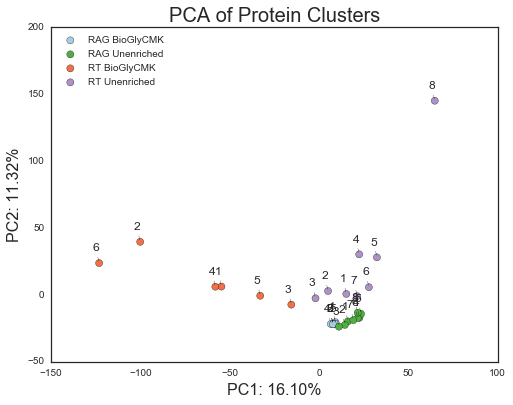

In [22]:
df = build_loci.to_df(grouped_loci, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[unenr_keys+enr_keys], group_name='category', loc=2, label_points=True)

# Filtering out potential Outliers

In [23]:
def remove_prob_sample(prob_samp_numb, all_keys, l_keys, h_keys):

    problem_samples = []
    problem_samples.append(l_keys[prob_samp_numb-1])
    problem_samples.append(h_keys[prob_samp_numb-1])

    # Copy keys so orignials are not modified
    return_all_keys = all_keys.copy()
    return_l_keys = l_keys.copy()
    return_h_keys = h_keys.copy()
    
    for sample in problem_samples:
        return_all_keys.remove(sample)
        if sample in l_keys:
            return_l_keys.remove(sample)
        if sample in h_keys:
            return_h_keys.remove(sample)
    
    return return_all_keys, return_l_keys, return_h_keys

In [24]:
# Boilerplate stuff
unenr_keys_f, rt_un_keys_f, rag_un_keys_f = unenr_keys.copy(), rt_un_keys.copy(), rag_un_keys.copy()
enr_keys_f, rt_enr_keys_f, rag_enr_keys_f = enr_keys.copy(), rt_enr_keys.copy(), rag_enr_keys.copy()

In [25]:
enr_keys_f, rt_enr_keys_f, rag_enr_keys_f = remove_prob_sample(1, enr_keys, rt_enr_keys, rag_enr_keys)
filt_clusters_f = {k:v for k, v in filt_clusters.items() if k in enr_keys_f}
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in enr_keys_f}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in enr_keys_f}
enr_grouped_loci_f = build_loci.group_across_samples(list(chain(*filt_clusters_f.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(enr_grouped_loci_f):
    locus.annotate()
    locus.quantify(rt_enr_keys_f) #Only quantify ratios across N14 identifications
    
enr_samples_f = {k:v for k, v in samples.items() if k in enr_keys_f}
nf = build_loci.yates_normalization(enr_samples_f)
for locus in enr_grouped_loci_f:
    locus.normalize(nf)
utils.save(enr_grouped_loci_f, os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"), force=True)

"""
enr_grouped_loci_f = utils.load(os.path.join(BASE,"enriched_grouped_loci_filt1.pkl.gz"))

explained variance ratios: [ 0.34227595  0.27816346]


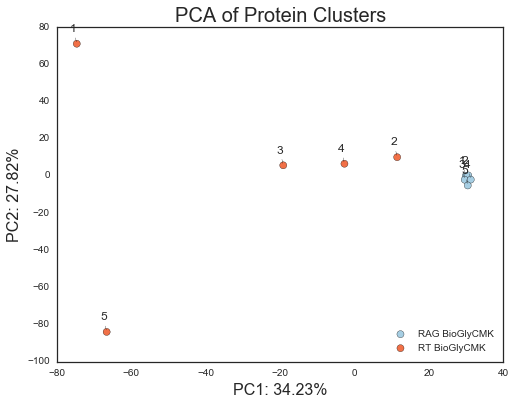

In [26]:
df = build_loci.to_df(enr_grouped_loci_f, ratios=False, peptides=True)
build_loci.plot_pca(df, metadata[enr_keys_f], group_name='category', loc=4, label_points=True)

In [27]:
unenr_clusters_f = {k:v for k, v in protein_clusters.items() if k in unenr_keys_f}
both_clusters_f = filt_clusters_f
both_clusters_f.update(unenr_clusters_f)
both_keys_f = enr_keys_f + unenr_keys_f

In [28]:
"""
sample_pep_quant = {samples[k].sample_name:samples[k].pep_quant for k in both_keys_f}
sample_quant_dict = {samples[k].sample_name:samples[k]['n15'] for k in both_keys_f}
grouped_loci_f = build_loci.group_across_samples(list(chain(*both_clusters_f.values())), sample_pep_quant, sample_quant_dict, db_info)
for locus in tqdm(grouped_loci_f):
    locus.annotate()
    locus.quantify(rt_un_keys_f+rt_enr_keys_f) #Only quantify ratios across N14 identifications

both_samples_f = {k:v for k, v in samples.items() if k in both_keys_f}
nf = build_loci.yates_normalization(both_samples_f)
for locus in grouped_loci_f:
    locus.normalize(nf)    

utils.save(grouped_loci_f, os.path.join(BASE,"grouped_loci_filt1.pkl.gz"), force=True)
"""
grouped_loci_f = utils.load(os.path.join(BASE,"grouped_loci_filt1.pkl.gz"))

explained variance ratios: [ 0.19920871  0.17019971]


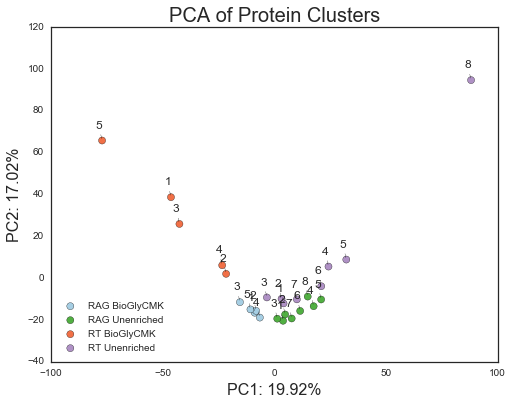

In [29]:
df = build_loci.to_df(grouped_loci_f, ratios=False, peptides=False)
build_loci.plot_pca(df, metadata[unenr_keys_f+enr_keys_f], group_name='category', loc=3, label_points=True)

## Multiple Test Correction for p-values

In [30]:
def benjamin_hochberg_correction(grouped_loci):
    """ Benjamin-Hochberg adjusts p-values to corrected for multiple testing.
    This is calculated by sorting the p-values and giving them a rank (i) from
    1 to the number of observations (m). The adjusted value is then calculated
    as p_adj = (m/i) * p.  However, if the adj value of p[i+1] is smaller, that
    value is used instead.  
    
    This is because while looking at the p-values inincreasig rank order, there
    will beat some cutoff value equal to the true FDR, where the p_adj becomes 
    lower than the inital p.  
    """
    
    
    p_vals = []
    for locus in grouped_loci:
        if locus.p_value == locus.p_value: # skip nan values
            p_vals.append(locus.p_value)

    p_vals = sorted(p_vals)

    p_adj = {}
    m = len(p_vals)
    for i, p in enumerate(p_vals):
        p1 = (m/(i+1)) * p

        if i < m-1:
            p2 = (m/(i+2)) * p_vals[i+1]

        if p1 < p2:
            p_adj[p] = p1
        else:
            p_adj[p] = p2

    for locus in grouped_loci:
        if locus.p_value == locus.p_value: # skip nan-values
            locus.p_value = p_adj[locus.p_value]

### Before Correction

In [31]:
u = 0
d = 0
for locus in unenr_grouped_loci:
    if locus.p_value < .05 and locus.avg_ratio > 2:
        u += 1
    if locus.p_value < .05 and locus.avg_ratio < .5:
        d += 1
print('UNENRICHED')
print("Significantly More abundent in IBD: {}".format(u))
print("Significantly More abundent in RAG: {}".format(d))


u = 0
d = 0
for locus in enr_grouped_loci_f:
    if locus.p_value < .05 and locus.avg_ratio > 2:
        u += 1
    if locus.p_value < .05 and locus.avg_ratio < .5:
        d += 1
print('\nBioGlyCMK')
print("Significantly More abundent in IBD: {}".format(u))
print("Significantly More abundent in RAG: {}".format(d))


UNENRICHED
Significantly More abundent in IBD: 219
Significantly More abundent in RAG: 248

BioGlyCMK
Significantly More abundent in IBD: 112
Significantly More abundent in RAG: 109


In [32]:
benjamin_hochberg_correction(unenr_grouped_loci)
benjamin_hochberg_correction(enr_grouped_loci_f)

### After Correction

In [33]:
u = 0
d = 0
for locus in unenr_grouped_loci:
    if locus.p_value < .05 and locus.avg_ratio > 2:
        u += 1
    if locus.p_value < .05 and locus.avg_ratio < .5:
        d += 1
print('UNENRICHED')
print("Significantly More abundent in IBD: {}".format(u))
print("Significantly More abundent in RAG: {}".format(d))


u = 0
d = 0
for locus in enr_grouped_loci_f:
    if locus.p_value < .05 and locus.avg_ratio > 2:
        u += 1
    if locus.p_value < .05 and locus.avg_ratio < .5:
        d += 1
print('\nBioGlyCMK')
print("Significantly More abundent in IBD: {}".format(u))
print("Significantly More abundent in RAG: {}".format(d))


UNENRICHED
Significantly More abundent in IBD: 89
Significantly More abundent in RAG: 112

BioGlyCMK
Significantly More abundent in IBD: 54
Significantly More abundent in RAG: 47


In [34]:
"""
utils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci_adj.pkl.gz"), force=True)
utils.save(enr_grouped_loci_f, os.path.join(BASE,"enriched_grouped_loci_filt1_adj.pkl.gz"), force=True)
"""

'\nutils.save(unenr_grouped_loci, os.path.join(BASE,"unenriched_grouped_loci_adj.pkl.gz"), force=True)\nutils.save(enr_grouped_loci_f, os.path.join(BASE,"enriched_grouped_loci_filt1_adj.pkl.gz"), force=True)\n'

In [35]:
build_loci.sig_up_json(unenr_grouped_loci, rt_un_keys, os.path.join(BASE, 'all_unenriched_sig_up.json'), fc_cutoff=2, norm=False)
build_loci.sig_down_json(unenr_grouped_loci, rt_un_keys, os.path.join(BASE, 'all_unenriched_sig_down.json'), fc_cutoff=2, norm=False)

## The list of up and downregulated Protein Clusters can be found here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_unenriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_unenriched_sig_down)**

### Enriched Samples

In [36]:
build_loci.sig_up_json(enr_grouped_loci_f, rt_enr_keys, os.path.join(BASE, 'all_enriched_sig_up.json'), fc_cutoff=2, norm=False)
build_loci.sig_down_json(enr_grouped_loci_f, rt_enr_keys, os.path.join(BASE, 'all_enriched_sig_down.json'), fc_cutoff=2, norm=False)

## View Significance tables here:  
**[Significantly upregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_enriched_sig_up)**  
**[Significantly downregulated in Tcell Transfer](http://wl-cmadmin:8000/ratiotable/all_enriched_sig_down)**

In [37]:
dat = build_loci.get_sig_df(enr_grouped_loci_f, up_only=True).query('passes')

In [38]:
dat

,id,p_value,avg_ratio,name,-logp,logfc,passes
132,62702093,0.041724,6.771905,gi|325956057|ref|YP_004286667.1| aminopeptidas...,1.379616,2.759562,True
197,17564385,0.043901,7.035590,gi|295692765|ref|YP_003601375.1| enolase [Lact...,1.357523,2.814671,True
199,20857573,0.043301,5.844504,MH0090_GL0084723 [gene] locus=scaffold1361_1...,1.363506,2.547081,True
753,51309162,0.041068,5.269110,SRS055982.54995-T1-C,1.386498,2.397559,True
801,166095654,0.027901,4.991147,MC-0-1_GL0078976_1_1202_+,1.554378,2.319371,True
815,61524829,0.031624,9.329752,sp|Q9Z0L8|GGH_MOUSE Gamma-glutamyl hydrolase O...,1.499982,3.221839,True
1261,165646758,0.026931,7.123708,sp|Q61878|PRG2_MOUSE Bone marrow proteoglycan ...,1.569747,2.832628,True
1415,32339000,0.043695,9.430959,gi|523687501|ref|WP_020806594.1| cysteine amin...,1.359570,3.237405,True
1654,8550204,0.042248,7.617111,gi|385813028|ref|YP_005849421.1| Peptidase C1-...,1.374191,2.929244,True
1685,9967533,0.023242,5.030272,gi|479130593|ref|YP_005070553.1| pentapeptide ...,1.633734,2.330636,True


# GO Term Characterization

See what amount of identified have GO Term annotations


In [39]:
c = 0
t = 0
spirulina = {129910, 35823, 118562, 376219}
human_mouse = {9606, 10090, 314146}
for locus in unenr_grouped_loci:
    if len(set(locus.tax_id) & (spirulina | human_mouse)) == 0:
        t += 1
        if 'go' in locus.annotations:
            c += 1
    
print('{0:1.2f}% of the {1} microbiome protiens found with go term annotations'.format(c/t*100, t))

83.58% of the 2893 microbiome protiens found with go term annotations


In [40]:
c = 0
t = 0
spirulina = {129910, 35823, 118562, 376219}
human_mouse = {9606, 10090, 314146}
for locus in enr_grouped_loci_f:
    if len(set(locus.tax_id) & (spirulina | human_mouse)) == 0:
        t += 1
        if 'go' in locus.annotations:
            c += 1
    
print('{0:1.2f}% of the {1} microbiome protiens found with go term annotations'.format(c/t*100, t))

83.24% of the 1987 microbiome protiens found with go term annotations
